In [1]:
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 27.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found


In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Ruta a la ubicación del conjunto de datos
#Path trabaja con rutas de archivos
DATASET_PATH = 'drive/MyDrive/I.A/AudiosDef'
data_dir = pathlib.Path(DATASET_PATH)

In [5]:
#Almacenamos la lista de directorios y archivos presentes en data_dir
individuos = np.array(tf.io.gfile.listdir(str(data_dir)))
#Eliminación de los elementos con nombre: .ipynb_checkpoints
#Directorio creado automaticamente y no suelen tener info relevante
individuos = individuos[individuos != '.ipynb_checkpoints']
print('Individuos:', individuos)

Individuos: ['Jamlilyn' 'Sergio' 'Fernando' 'Diego' 'Anthony' 'Pablo' 'Mattew']


In [6]:
tf.io.gfile.listdir(data_dir)

['Jamlilyn', 'Sergio', 'Fernando', 'Diego', 'Anthony', 'Pablo', 'Mattew']

In [7]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = [f for f in filenames if '.ipynb_checkpoints' not in f]

In [8]:
filenames = tf.random.shuffle(filenames) #Ordena de manera aleatorio los elementos en la lista
num_samples = len(filenames)
print('Total de ejemplos:', num_samples)

label_dir = str(data_dir / individuos[0])
num_label_samples = len(tf.io.gfile.listdir(label_dir))
print('Ejemplos por etiqueta:', num_label_samples)

num_etiquetas = len(individuos)
print('Número de etiquetas:', num_etiquetas)

Total de ejemplos: 420
Ejemplos por etiqueta: 60
Número de etiquetas: 7


In [9]:
#Conjunto de elementos designados para:
train_files = filenames[:252] # 60%
val_files = filenames[252: 336] # 20%
test_files = filenames[336:] # 20%

print('Tamaño del conjunto de entrenamiento: ', len(train_files))
print('Tamaño del conjunto de validación: ', len(val_files))
print('Tamaño del conjunto de pruebas: ', len(test_files))

Tamaño del conjunto de entrenamiento:  252
Tamaño del conjunto de validación:  84
Tamaño del conjunto de pruebas:  84


In [10]:
#Decodificación de un fragmento para visualizar la forma del tensor de audio
test_file = tf.io.read_file('drive/MyDrive/I.A/AudiosDef/Anthony/Anthony_grabacion24.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

**FUNCIONES**

In [11]:
#Decodificación del archivo en formato WAV
def decodificar_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)

In [12]:
#Obtención de la etiqueta
def obtener_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2] #retorna el nombre de la penúltima posición de la ruta

Por ejemplo:

'drive/MyDrive/I.A/AudiosDef/Anthony/Anthony_grabacion24.wav', después de dividirlo en partes y seleccionar el elemento -2, obtendremos la etiqueta 'Anthony', que es el nombre del directorio en la penúltima posición de la ruta.

In [13]:
#Devolución de la forma de onda y la etiqueta como una tupla
def waveform_label(file_path):
  label = obtener_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decodificar_audio(audio_binary)
  return waveform, label

In [15]:
AUTOTUNE = tf.data.AUTOTUNE #Optimiza la lectura y procesamiento de datos de forma paralelo
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(
    map_func= waveform_label,
    num_parallel_calls=AUTOTUNE)

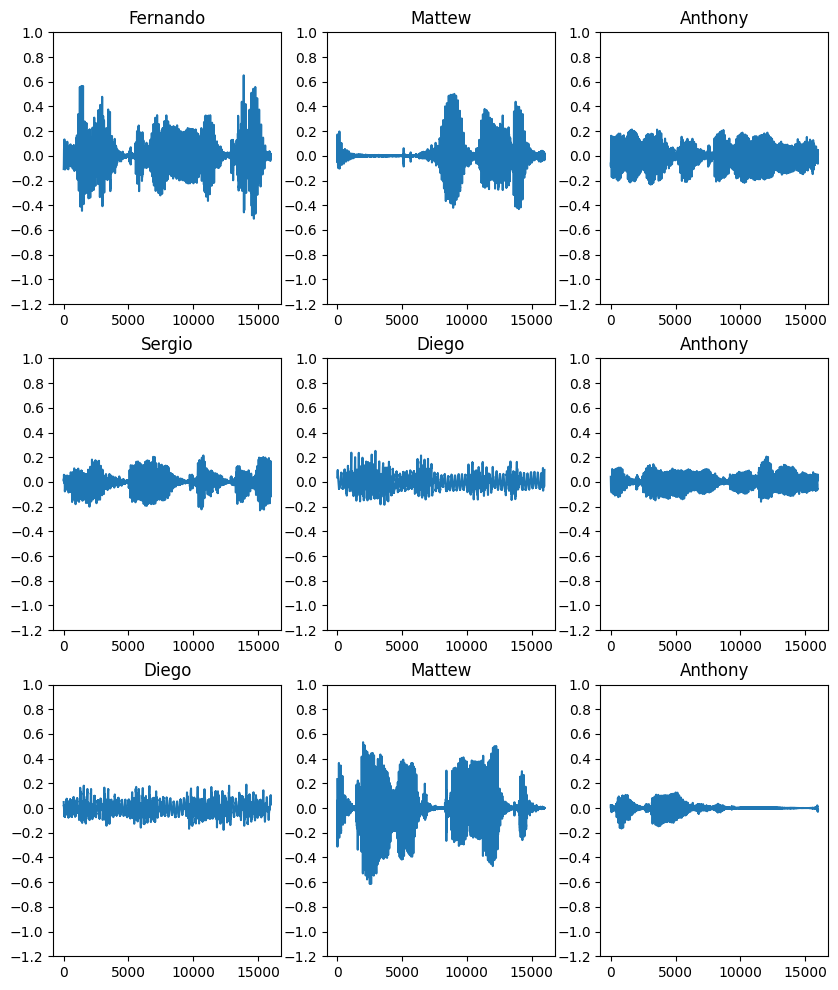

In [16]:
#Presentación de algunas formas de audio con su respectiva etiqueta
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

Un espectrograma es una representación gráfica que muestra cómo varía la energía de diferentes frecuencias a lo largo del tiempo en una señal de audio.

El espectrograma resultante es una representación visual de las frecuencias y su energía en función del tiempo en la señal de audio. Esta representación es útil para el análisis y procesamiento de señales de audio en aplicaciones de procesamiento de señales de audio, análisis de música, procesamiento de voz y reconocimiento de patrones.

In [17]:
#Conversión de forma de ona a espectograma
def obtener_spectrogram(waveform):

  #Asegurar que la forma de onda tengo 16K muestras
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  #Conversión a tipo de dato a punto flotante
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  #Calculo de espectograma utilizando una Transformada de Fourier de tiempo recducido (STFT)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram) #Magnitud de STFT

  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [19]:
#Procesamiento de una uestra para obtener su espectograma
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = obtener_spectrogram(waveform)

print('Etiqueta:', label)
print('Forma de Onda:', waveform.shape)
print('Forma de espectrograma:', spectrogram.shape)
print('Reproducción de audio')
display.display(display.Audio(waveform, rate=16000))

Etiqueta: Fernando
Forma de Onda: (16000,)
Forma de espectrograma: (124, 129, 1)
Reproducción de audio


In [20]:
#Visualizar un espectrograma con mapa de colores
def plot_spectrogram(spectrogram, ax):
  #Analisis de dimensionalidad
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

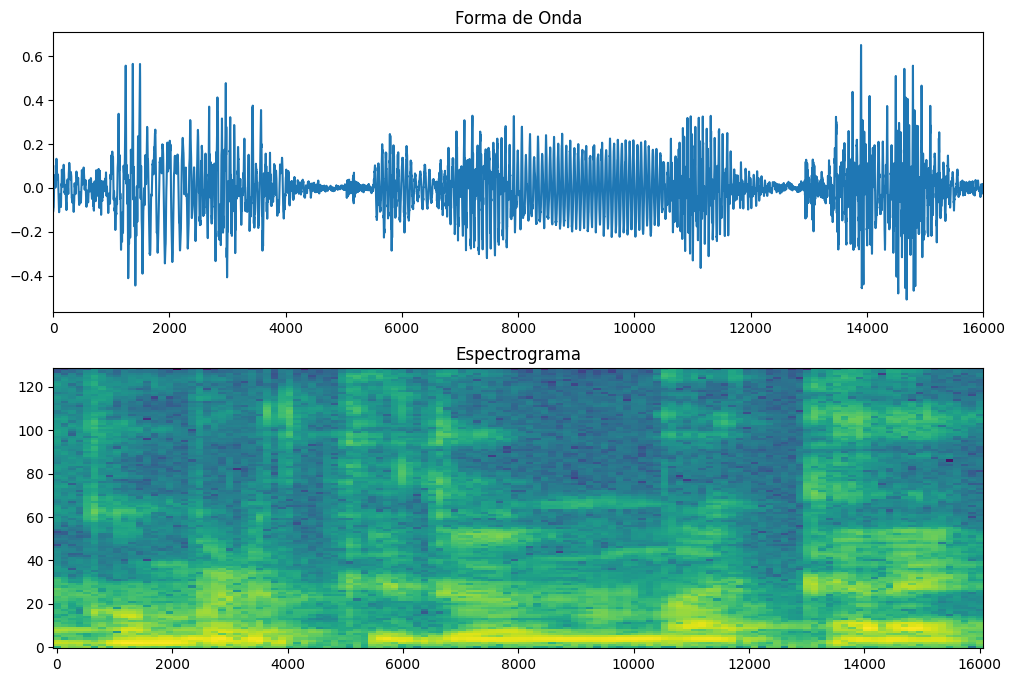

In [21]:
#Comparación entre la waveform y spectrogram / tasa de muestreo = 16000
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])

axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Forma de Onda')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Espectrograma')
plt.show()

In [22]:
#Devuelve espectrograma del audio con el ID numérico asociado a la etiqueta
def Obtener_spectrogram_label_id(audio, label):
  spectrogram = obtener_spectrogram(audio)
  label_id = tf.argmax(label == individuos)
  return spectrogram, label_id

In [23]:
#Contiene las tuplas del espectrograma y el ID numérico de la etiqueta, en un nuevo dataset
spectrogram_ds = waveform_ds.map(
  map_func=Obtener_spectrogram_label_id,
  num_parallel_calls=AUTOTUNE)

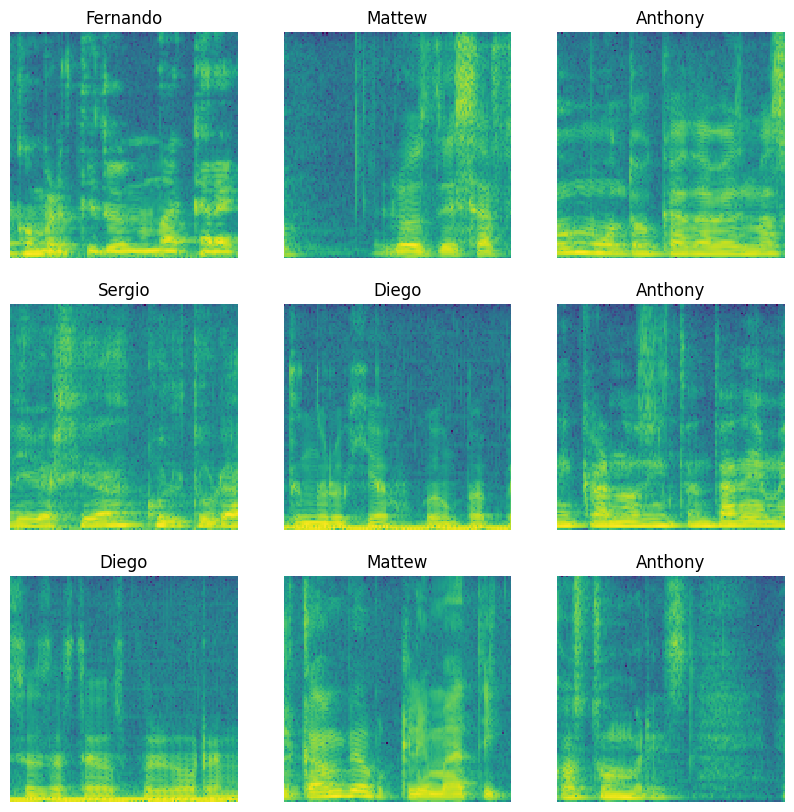

In [24]:
#Presentación de algunos espectrogramas con su respectiva etiqueta
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(individuos[label_id.numpy()])
  ax.axis('off')

plt.show()

In [25]:
#Preprocesamiento para listas de archivos
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map( map_func=waveform_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map( map_func=Obtener_spectrogram_label_id, num_parallel_calls=AUTOTUNE)
  return output_ds

In [26]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [27]:
batch_size = 8 #Tamaño de la semilla, 1% o 2% de la data
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
#test_ds = test_ds.batch(batch_size)

In [28]:
#Optimización de tiempos de lectura y preproces de datos con: cache() y prefetch(AUTOTUNE)
#Carga los datos mientras se entrena o evalua
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
#test_ds = test_ds.cache().prefetch(AUTOTUNE)

Las redes neuronales convolucionales son una opción para la identificación de voz debido a su capacidad para aprender características relevantes directamente de los datos, capturar patrones tanto espaciales como temporales, y generalizar bien a nuevos datos. Esto hace que las CNN sean capaces de abordar tareas de clasificación de audio y análisis de señales de voz.

In [56]:
#Arquitectura del modelo: CNN (Red Neuronal Convolucional)
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Forma de espectrograma de entrada:', input_shape)

num_labels = len(individuos)
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])
model.summary()

Forma de espectrograma de entrada: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 drop

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [31]:
#Entrenamiento del modelo CNN
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    #Detención del entrenamiento si no se observa una mejora en la métrica de validación
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
32/32 [==============================] - 11s 341ms/step - loss: 1.7492 - accuracy: 0.2460 - val_loss: 1.4323 - val_accuracy: 0.3929
Epoch 2/50
32/32 [==============================] - 1s 30ms/step - loss: 1.2735 - accuracy: 0.5040 - val_loss: 1.0205 - val_accuracy: 0.6786
Epoch 3/50
32/32 [==============================] - 1s 31ms/step - loss: 0.9430 - accuracy: 0.6548 - val_loss: 0.8326 - val_accuracy: 0.6429
Epoch 4/50
32/32 [==============================] - 1s 32ms/step - loss: 0.7477 - accuracy: 0.7222 - val_loss: 0.7501 - val_accuracy: 0.7262
Epoch 5/50
32/32 [==============================] - 1s 33ms/step - loss: 0.5583 - accuracy: 0.8016 - val_loss: 0.6154 - val_accuracy: 0.8333
Epoch 6/50
32/32 [==============================] - 1s 38ms/step - loss: 0.4799 - accuracy: 0.8294 - val_loss: 0.4803 - val_accuracy: 0.8333
Epoch 7/50
32/32 [==============================] - 1s 44ms/step - loss: 0.3396 - accuracy: 0.8770 - val_loss: 0.5157 - val_accuracy: 0.8333
Epoch 8/50


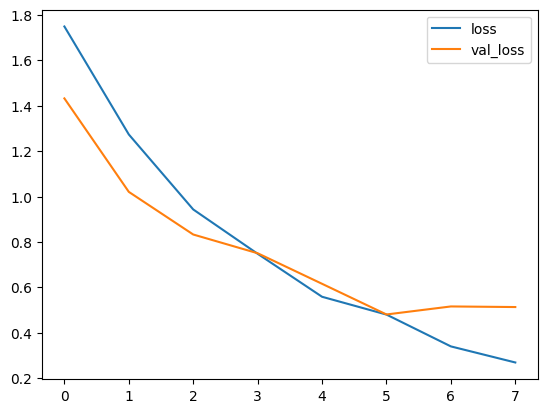

In [32]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

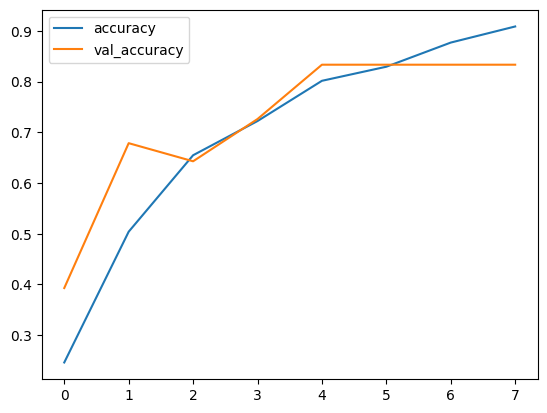

In [33]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

Creación de listas vacias para almacenar las formas de onda de audio y las etiquetas del conjunto de pruebas, entrenamiento y validación respectivamente. Estos datos se pueden utilizar para evaluar el rendimiento del modelo en el conjunto de pruebas, entrenamiento, validación y realizar predicciones sobre nuevos datos.

In [34]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [35]:
train_audio = []
train_labels = []

for audio, label in train_ds:
  train_audio.append(audio)
  train_labels.append(label)

train_audio = tf.concat(train_audio, axis=0)
train_labels = tf.concat(train_labels, axis=0)

In [36]:
val_audio = []
val_labels = []

for audio, label in val_ds:
  val_audio.append(audio)
  val_labels.append(label)

val_audio = tf.concat(val_audio, axis=0)
val_labels = tf.concat(val_labels, axis=0)

In [37]:
#Predicción sobre el conjunto de pruebas
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Accuracy del conjunto de prueba: {test_acc:.0%}')

3/3 [==============================] - 0s 23ms/step
Accuracy del conjunto de prueba: 85%


In [38]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.90      0.90      0.90        10
           2       0.82      1.00      0.90        14
           3       1.00      1.00      1.00        11
           4       0.67      0.91      0.77        11
           5       0.82      0.64      0.72        14
           6       0.83      0.77      0.80        13

    accuracy                           0.85        84
   macro avg       0.86      0.85      0.85        84
weighted avg       0.86      0.85      0.84        84



In [39]:
#Predicción sobre el conjunto de entrenamiento
y_predT = np.argmax(model.predict(train_audio), axis=1)
y_trueT = train_labels.numpy()

train_acc = sum(y_predT == y_trueT) / len(y_trueT)
print(f'Accuracy del conjunto de entrenamiento: {train_acc:.0%}')

8/8 [==============================] - 0s 20ms/step
Accuracy del conjunto de entrenamiento: 100%


In [40]:
print(classification_report(y_trueT,y_predT))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        36
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00        34
           6       1.00      1.00      1.00        34

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252



In [41]:
#Predicción sobre el conjunto de validación
y_predV = np.argmax(model.predict(val_audio), axis=1)
y_trueV = val_labels.numpy()

val_acc = sum(y_predV == y_trueV) / len(y_trueV)
print(f'Accuracy del conjunto de validación: {val_acc:.0%}')

3/3 [==============================] - 0s 18ms/step
Accuracy del conjunto de validación: 83%


In [42]:
print(classification_report(y_trueV,y_predV))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       1.00      0.93      0.96        14
           2       0.57      1.00      0.73         8
           3       1.00      1.00      1.00        11
           4       0.71      0.92      0.80        13
           5       0.90      0.75      0.82        12
           6       0.86      0.46      0.60        13

    accuracy                           0.83        84
   macro avg       0.85      0.84      0.83        84
weighted avg       0.86      0.83      0.83        84



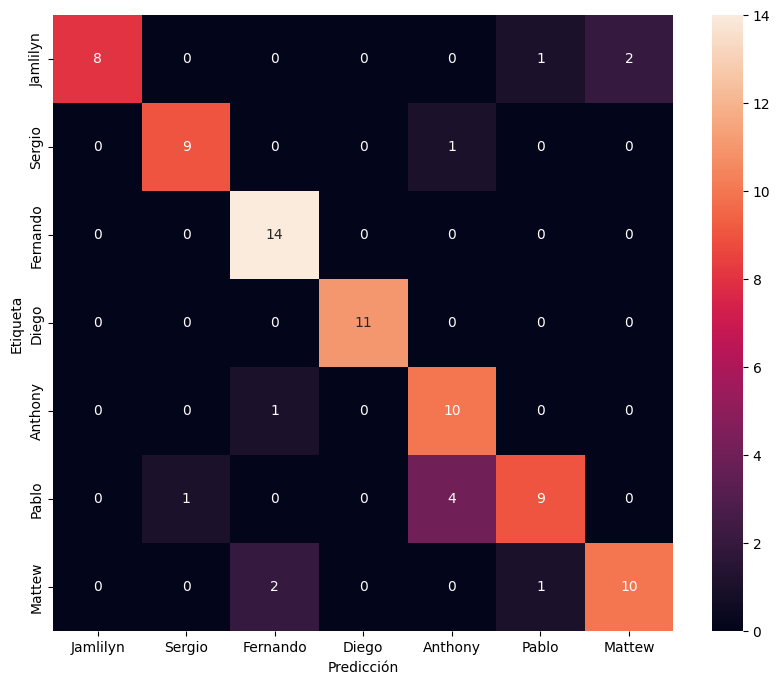

In [43]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=individuos,
            yticklabels=individuos,
            annot=True, fmt='g')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta')
plt.show()

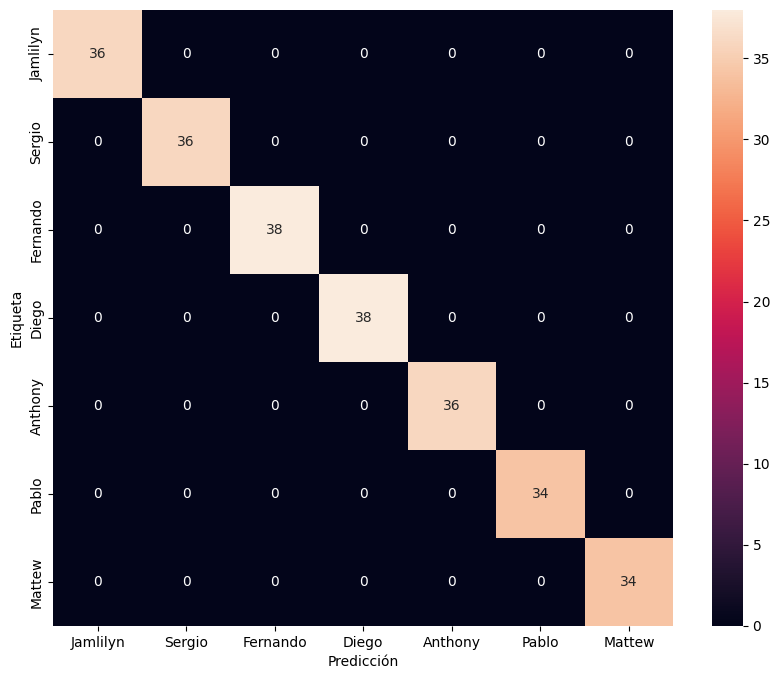

In [44]:
confusion_mtx = tf.math.confusion_matrix(y_trueT, y_predT)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=individuos,
            yticklabels=individuos,
            annot=True, fmt='g')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta')
plt.show()

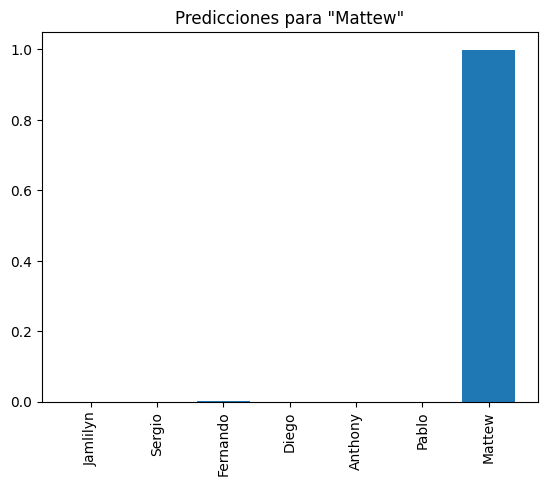

In [45]:
sample_file = 'drive/MyDrive/I.A/AudiosDef/Mattew/Mattew_grabacion11.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(individuos, tf.nn.softmax(prediction[0])) #altura de barras
  plt.title(f'Predicciones para "{individuos[label[0]]}"')
  # Configurar orientación de etiquetas predichas a vertical
  plt.xticks(rotation=90)
  plt.show()

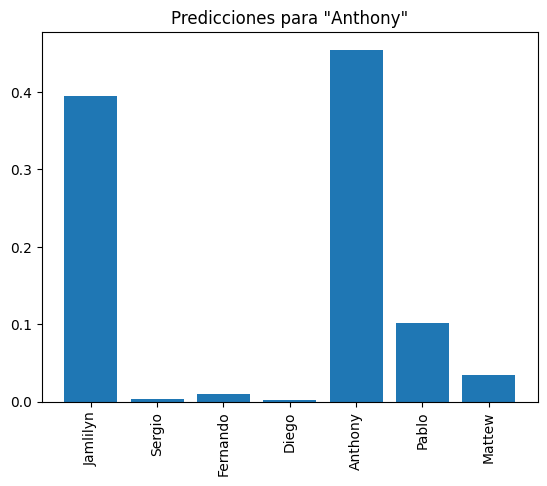

In [46]:
sample_file = 'drive/MyDrive/I.A/AudiosDef/Anthony/Anthony_grabacion1.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(individuos, tf.nn.softmax(prediction[0]))
  plt.title(f'Predicciones para "{individuos[label[0]]}"')
  # Configurar orientación de etiquetas predichas a vertical
  plt.xticks(rotation=90)
  plt.show()

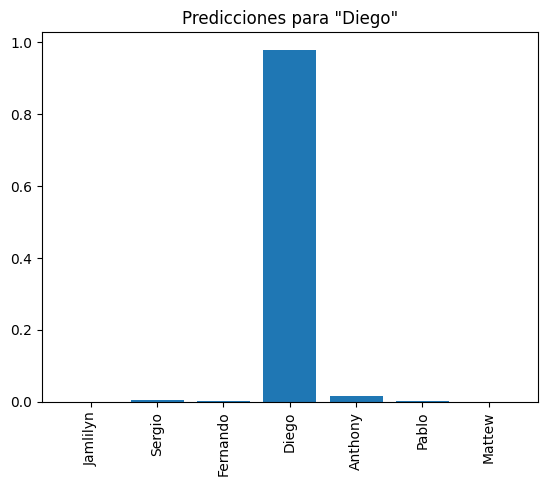

In [47]:
sample_file = 'drive/MyDrive/I.A/AudiosDef/Diego/Diego_grabacion41.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(individuos, tf.nn.softmax(prediction[0]))
  plt.title(f'Predicciones para "{individuos[label[0]]}"')
  # Configurar orientación de etiquetas predichas a vertical
  plt.xticks(rotation=90)
  plt.show()

Nombre de individuo "Sergio"


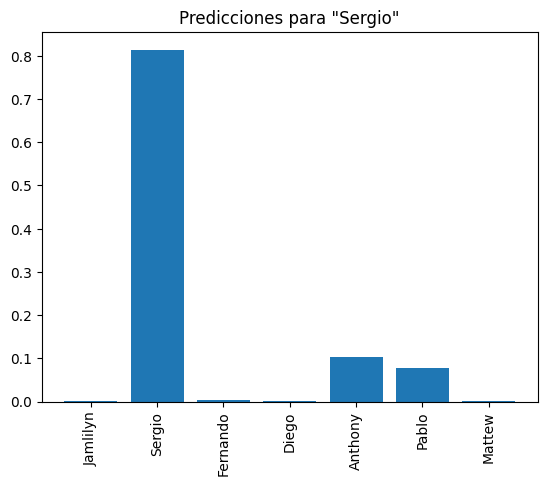

In [48]:
sample_file = 'drive/MyDrive/I.A/AudiosDef/Sergio/Sergio_grabacion52.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  label_pred = np.argmax(prediction, axis = 1)
  print('Nombre de individuo "'+individuos[label_pred[0]]+'"')
  plt.bar(individuos, tf.nn.softmax(prediction[0]))
  plt.title(f'Predicciones para "{individuos[label[0]]}"')
  # Configurar orientación de etiquetas predichas a vertical
  plt.xticks(rotation=90)
  plt.show()

# Guardar y descargar el modelo

In [49]:
# Predicción sobre el conjunto de pruebas
probabilidades = tf.nn.softmax(model.predict(test_audio))
clases_predichas = np.argmax(probabilidades, axis=1)
y_true = test_labels

test_acc = sum(clases_predichas == y_true) / len(y_true)
print(f'Accuracy del conjunto de prueba: {test_acc:.0%}')

# Para cada predicción, imprime la clase y la probabilidad.
for i in range(len(test_audio)):
    print(f"Audio {i}: {clases_predichas[i]} con un {max(probabilidades[i])*100:.2f}% de seguridad.")

# Predicción sobre el conjunto de entrenamiento
probabilidadesT = tf.nn.softmax(model.predict(train_audio))
clases_predichasT = np.argmax(probabilidadesT, axis=1)
y_trueT = train_labels.numpy()

train_acc = sum(clases_predichasT == y_trueT) / len(y_trueT)
print(f'Accuracy del conjunto de entrenamiento: {train_acc:.0%}')

# Predicción sobre el conjunto de validación
probabilidadesV = tf.nn.softmax(model.predict(val_audio))
clases_predichasV = np.argmax(probabilidadesV, axis=1)
y_trueV = val_labels.numpy()

val_acc = sum(clases_predichasV == y_trueV) / len(y_trueV)
print(f'Accuracy del conjunto de validación: {val_acc:.0%}')

model.save('modelo_entrenado.h5')

umbral = 0.85

for i in range(len(test_audio)):
    max_prob = max(probabilidades[i])
    if max_prob < umbral:
        print(f"Audio {i} no se encuentra en la base de datos.")
    else:
        print(f"Audio {i}: {clases_predichas[i]} con un {max_prob*100:.2f}% de seguridad.")


3/3 [==============================] - 0s 23ms/step
Accuracy del conjunto de prueba: 85%
Audio 0: 3 con un 99.74% de seguridad.
Audio 1: 2 con un 99.25% de seguridad.
Audio 2: 5 con un 78.46% de seguridad.
Audio 3: 1 con un 69.44% de seguridad.
Audio 4: 4 con un 89.18% de seguridad.
Audio 5: 1 con un 85.42% de seguridad.
Audio 6: 3 con un 97.91% de seguridad.
Audio 7: 2 con un 79.66% de seguridad.
Audio 8: 5 con un 61.72% de seguridad.
Audio 9: 6 con un 56.37% de seguridad.
Audio 10: 2 con un 87.89% de seguridad.
Audio 11: 3 con un 94.33% de seguridad.
Audio 12: 4 con un 55.31% de seguridad.
Audio 13: 6 con un 82.39% de seguridad.
Audio 14: 3 con un 99.41% de seguridad.
Audio 15: 0 con un 65.40% de seguridad.
Audio 16: 4 con un 74.06% de seguridad.
Audio 17: 2 con un 94.57% de seguridad.
Audio 18: 5 con un 83.59% de seguridad.
Audio 19: 0 con un 50.61% de seguridad.
Audio 20: 4 con un 36.60% de seguridad.
Audio 21: 1 con un 83.31% de seguridad.
Audio 22: 6 con un 99.86% de seguridad.
A

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Audio 27: 4 con un 95.13% de seguridad.
Audio 28: 4 con un 94.95% de seguridad.
Audio 29 no se encuentra en la base de datos.
Audio 30 no se encuentra en la base de datos.
Audio 31: 2 con un 100.00% de seguridad.
Audio 32: 3 con un 98.62% de seguridad.
Audio 33: 3 con un 98.67% de seguridad.
Audio 34 no se encuentra en la base de datos.
Audio 35 no se encuentra en la base de datos.
Audio 36: 4 con un 98.88% de seguridad.
Audio 37 no se encuentra en la base de datos.
Audio 38: 6 con un 97.92% de seguridad.
Audio 39: 2 con un 99.98% de seguridad.
Audio 40: 3 con un 98.96% de seguridad.
Audio 41: 6 con un 97.81% de seguridad.
Audio 42 no se encuentra en la base de datos.
Audio 43 no se encuentra en la base de datos.
Audio 44: 2 con un 100.00% de seguridad.
Audio 45: 3 con un 98.94% de seguridad.
Audio 46 no se encuentra en la base de datos.
Audio 47 no se encuentra en la base de datos.
Audio 48 no se encuentra en la base de datos.
Audio 49: 4 con un 97.31% de seguridad.
Audio 50: 2 con u

In [50]:
!zip -r ./modelo_entrenado.h5 ./modelo_entrenado

	zip warning: missing end signature--probably not a zip file (did you
	zip warning: remember to use binary mode when you transferred it?)
	zip warning: (if you are trying to read a damaged archive try -F)

zip error: Zip file structure invalid (./modelo_entrenado.h5)


In [51]:
#Verificación del modelo descargado
loaded_model = models.load_model("modelo_entrenado.h5")

In [52]:
model_cargado = keras.models.load_model('modelo_entrenado.h5')

Nombre de individuo "Sergio"


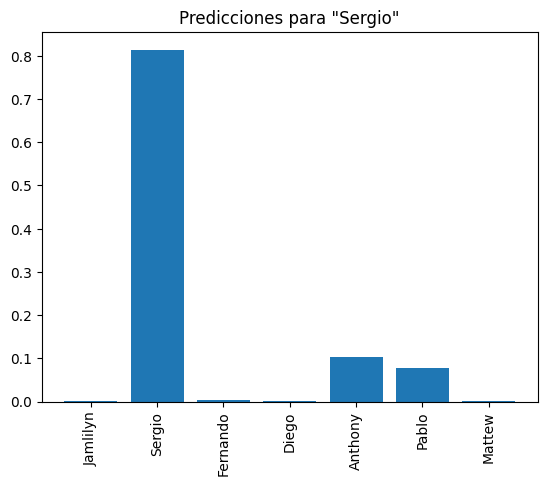

In [53]:
for spectrogram, label in sample_ds.batch(1):
  prediction = loaded_model(spectrogram)
  label_pred = np.argmax(prediction, axis = 1)
  print('Nombre de individuo "'+individuos[label_pred[0]]+'"')
  plt.bar(individuos, tf.nn.softmax(prediction[0]))
  plt.title(f'Predicciones para "{individuos[label[0]]}"')
  # Configurar orientación de etiquetas predichas a vertical
  plt.xticks(rotation=90)
  plt.show()

In [54]:
import wave

obj = wave.open(str(sample_file), 'rb')
n_samples = obj.getnframes() #numero de frames en un archivo wav
signal_wave = obj.readframes(n_samples) #Señal de onda
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
obj.close()
#Cantidad de muestras de un archivo de audio
print(signal_array.shape)

(16000,)


---
tf.Tensor(
[[-2.233015   4.9214263 -0.8297202 -1.906051   2.85506    2.5765772
  -2.6018426]], shape=(1, 7), dtype=float32)
---
Nombre de individuo "Sergio"


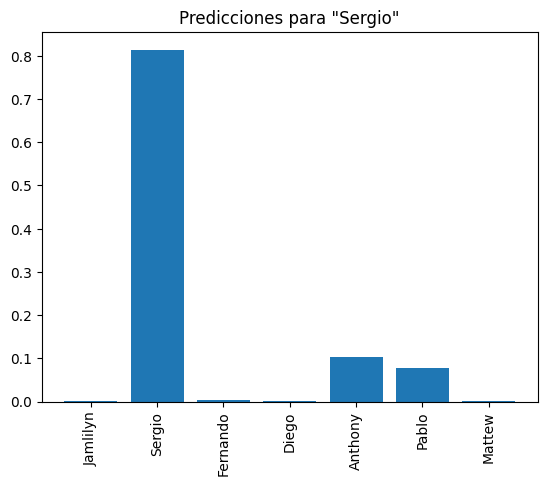

In [55]:
#Maximo valor posible, rango de valores de 16 bits con signo de -1 a 1
print("---")
waveform = signal_array / 32768
waveform = tf.convert_to_tensor(waveform, dtype= tf.float32)
spec = obtener_spectrogram(waveform)
spec = tf.expand_dims(spec, 0)
prediction = loaded_model(spec)
print(prediction)
print("---")
label_pred = np.argmax(prediction, axis = 1)
print('Nombre de individuo "'+individuos[label_pred[0]]+'"')
plt.bar(individuos, tf.nn.softmax(prediction[0]))
plt.title(f'Predicciones para "{individuos[label[0]]}"')
# Configurar orientación de etiquetas predichas a vertical
plt.xticks(rotation=90)
plt.show()